In [1]:
import os
import re
import pandas as pd
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

In [2]:
base_dirt = os.getcwd()
path = os.path.join(base_dirt, 'p3_data.csv')
data = pd.read_csv(path, encoding='ISO-8859-1')

In [3]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
corpus = data[['OriginalTweet','Sentiment']]

In [5]:
corpus.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [7]:
corpus.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [8]:
corpus['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [9]:
encoder = OrdinalEncoder(categories=[['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']])
corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])

C:\Users\tasnu\AppData\Local\Temp\ipykernel_7328\4240578442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])


In [10]:
corpus['Sentiment'].value_counts()

Sentiment
3.0    11422
1.0     9917
2.0     7713
4.0     6624
0.0     5481
Name: count, dtype: int64

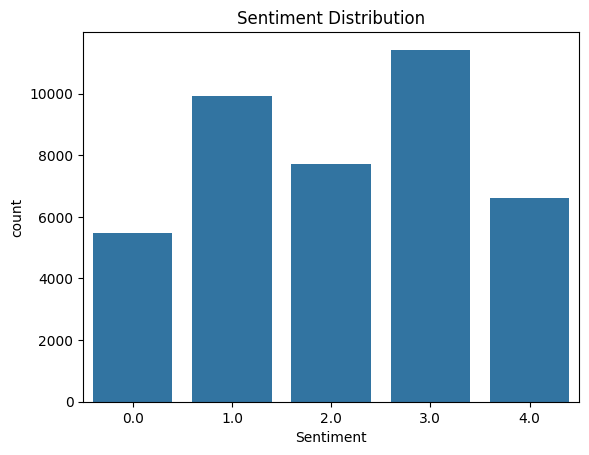

In [11]:
sns.countplot(x='Sentiment', data=corpus)
plt.title('Sentiment Distribution')
plt.show()

In [12]:
corpus['OriginalTweet'].sample(10).values

array(['@ManUtd and @ManCity will support local food banks to meet increased demand from vurnerable people, as a result of the coronavirus #covid-19 pendenic.\r\r\nWe are #AcityUnited https://t.co/ZmQaAoPR3n',
       'Top 100 Fastest Growing &amp; Declining Categories in E-commerce\r\r\n\r\r\nCOVID-19 affected consumer shopping behavior as well.StacklineÂ\xa0has put together a helpful infographic, which contains the top 100 fastest growing and top 100 declining categories in March\r\r\n\r\r\nLetÂ\x92s take a look!\r\r\n#COVID19 https://t.co/TYhVr3K3as',
       'How grocery store workers are dealing with the anxious crowds and high demand  \r\r\n\r\r\nhttps://t.co/RUdI6mW1qR\r\r\n\r\r\n#p2 #news #politics #coronavirus',
       'Now wish I had bought more alcohol than toiletpaper #Coronavirus #COVID19 #SouthAfrica #ExtendedLockdown',
       'Here s why betelnut prices have shot up in Port Moresby',
       'In all seriousness, how much am I really at risk for getting covid-19? IÂ\x92m 43 

In [13]:
def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


C:\Users\tasnu\AppData\Local\Temp\ipykernel_7328\2179563702.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


In [14]:
corpus['OriginalTweet'].sample(10).values

array(['Lack of Confidence to safely return to normal activities Lack of productivity disrupting food amp supply chain will further aggravate shortages Lack of income will further stress fears Pray Repent amp Prepare your house Stock Ration Save amp plan Security',
       'China Macro amp Metals As work slowly resumes high steel stocks weigh on prices By',
       'Ontario Man Soaks Coffee In Sanitizer Spray In Tim Hortons Drive Thru VIDEO If youre that worried why buy the coffee in the first place',
       'Check out Charmin LOT via',
       'Losing your minds and have been deceived by mass panic and paranoia Get a grip Covid will eventually be compared to influenza What happens when mass rioting happens because people lose their jobs have no money and no food',
       'Kids eat a lot in isolation If u see me at grocery store Im not panic buying Im lazy and these fuckfaces eat about lbs of feedday Surprised I dont need MORE toilet paper',
       'As giant amp projects face death goes C

In [15]:
corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()

C:\Users\tasnu\AppData\Local\Temp\ipykernel_7328\892715711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()


In [16]:
nltk.download('stopwords')

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    new_text = []

    for word in words:
        if word not in stop_words:
            new_text.append(word)
    
    return ' '.join(new_text)

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\tasnu\AppData\Local\Temp\ipykernel_7328\2800391941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)


In [17]:
def get_words(df, sentiment, n=10):
    sentiment_df = df[df['Sentiment'] == sentiment]

    all_words = []
    for tokens in sentiment_df['OriginalTweet']:
        for word in tokens.split():
            all_words.append(word)

    top_words = Counter(all_words).most_common(n)
    return dict(top_words)

positive_words = get_words(corpus, 3.0 , 10)
negative_words = get_words(corpus, 1.0, 10)
neutral_words = get_words(corpus, 2.0, 10)
extremely_positive_words = get_words(corpus, 4.0, 10)
extremely_negative_words = get_words(corpus, 0.0, 10)

print("Top 10 Extremely Positive Words:", extremely_positive_words)
print("Top 10 Positive Words:", positive_words)
print("Top 10 Neutral Words:", neutral_words)
print("Top 10 Negative Words:", negative_words)
print("Top 10 Extremely Negative Words:", extremely_negative_words)

Top 10 Extremely Positive Words: {'covid': 1655, 'store': 1258, 'amp': 1123, 'grocery': 1053, 'supermarket': 1032, 'help': 972, 'food': 961, 'hand': 938, 'prices': 931, 'sanitizer': 833}
Top 10 Positive Words: {'covid': 2933, 'store': 2014, 'prices': 2014, 'grocery': 1868, 'supermarket': 1814, 'food': 1718, 'people': 1429, 'amp': 1421, 'consumer': 1241, 'online': 1057}
Top 10 Neutral Words: {'covid': 1742, 'store': 1304, 'supermarket': 1241, 'prices': 1191, 'grocery': 1122, 'consumer': 904, 'shopping': 678, 'online': 666, 'food': 609, 'people': 599}
Top 10 Negative Words: {'covid': 2613, 'prices': 2350, 'food': 1941, 'supermarket': 1644, 'store': 1519, 'people': 1412, 'grocery': 1384, 'amp': 1078, 'consumer': 913, 'demand': 881}
Top 10 Extremely Negative Words: {'covid': 1539, 'food': 1531, 'prices': 1335, 'people': 1212, 'panic': 1137, 'supermarket': 902, 'crisis': 833, 'amp': 827, 'store': 662, 'buying': 646}


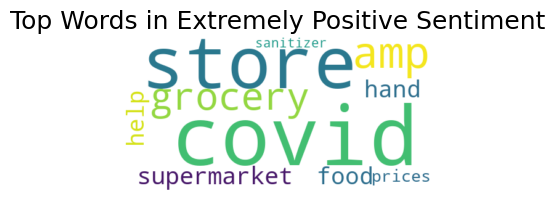

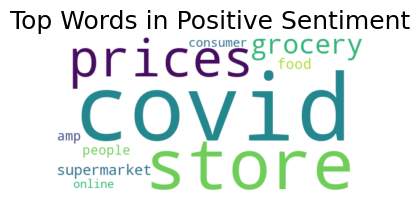

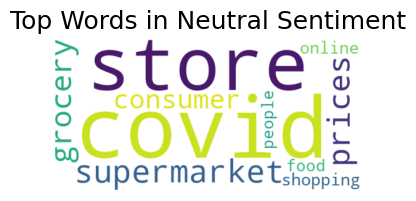

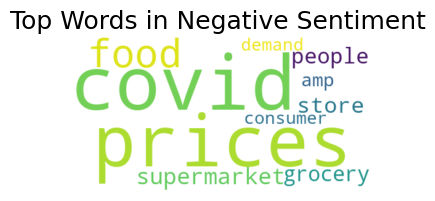

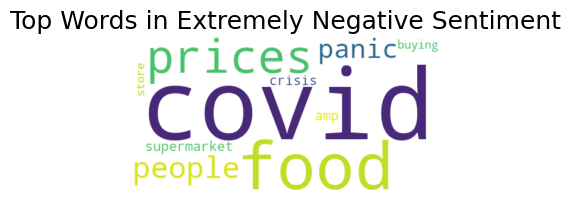

In [18]:
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=500, height=250, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(extremely_positive_words, 'Top Words in Extremely Positive Sentiment')
plot_wordcloud(positive_words, 'Top Words in Positive Sentiment')
plot_wordcloud(neutral_words, 'Top Words in Neutral Sentiment')
plot_wordcloud(negative_words, 'Top Words in Negative Sentiment')
plot_wordcloud(extremely_negative_words, 'Top Words in Extremely Negative Sentiment')

In [19]:
from nltk import ngrams

def class_ngrams(tokens, n):
    return list(ngrams(tokens, n))

def plot_ngrams(ngrams, title):
    ngram_labels = [' '.join(ngram[0]) for ngram in ngrams]
    ngram_counts = [ngram[1] for ngram in ngrams]
    
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [20]:
x = corpus['OriginalTweet']
y = corpus['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=50)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=50)


In [21]:
x_train

9804     great piece im son yo grocery store workers pu...
29987    treatment infection also manufactured erythrom...
14300    report manchester city manchester united donat...
7629     standard homes wont know lived without corpora...
31181    major chains beginning report first related em...
                               ...                        
21461    farmers shifting focus directtoconsumer sales ...
6055     know guy voted lowering drug prices aca denyin...
1364     sign times tissuetype paper left grocery store...
31739    exxon slashes capital spending percent oil pri...
3838     malaysia corona case gonna get lot worse blami...
Name: OriginalTweet, Length: 33336, dtype: object

In [22]:
nltk.download('punkt_tab')
x_train = x_train.apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
x_train

9804     [great, piece, im, son, yo, grocery, store, wo...
29987    [treatment, infection, also, manufactured, ery...
14300    [report, manchester, city, manchester, united,...
7629     [standard, homes, wont, know, lived, without, ...
31181    [major, chains, beginning, report, first, rela...
                               ...                        
21461    [farmers, shifting, focus, directtoconsumer, s...
6055     [know, guy, voted, lowering, drug, prices, aca...
1364     [sign, times, tissuetype, paper, left, grocery...
31739    [exxon, slashes, capital, spending, percent, o...
3838     [malaysia, corona, case, gon, na, get, lot, wo...
Name: OriginalTweet, Length: 33336, dtype: object

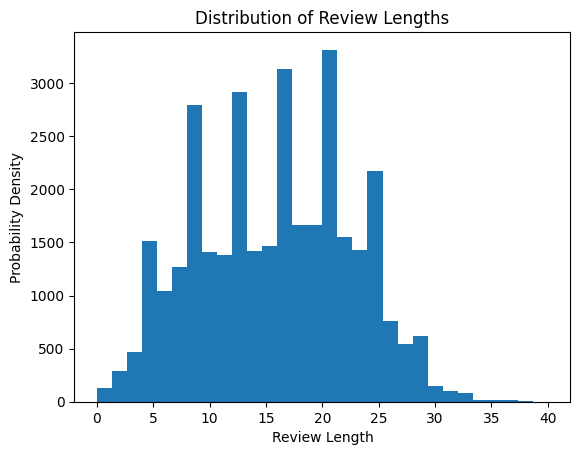

In [27]:
length = [len(token) for token in x_train]
print(max(length))

plt.hist(length, bins=30)
plt.xlabel('Length')
plt.ylabel('Number of instances')
plt.title('Distribution of Lengths')
plt.show()

In [29]:
word2vec_model = Word2Vec(
    sentences=x_train,  # The tokenized text data
    vector_size=300,  # Size of the word vectors (use 300 for Google News similarity)
    window=5,  # Context window size (how many words before/after to consider)
    min_count=1,  # Minimum word frequency for a word to be included in the model
    workers=4,  # Number of CPU threads to use
    sg=0  # Use CBOW (sg=0), or skip-gram (sg=1)
)

word2vec_model.build_vocab(x_train)
word2vec_model.train(x_train, total_examples=word2vec_model.corpus_count, epochs=10)

(4841174, 5208130)

In [ ]:
word2vec_model.save("word2vec_model.model")